In [3]:
import requests
import pandas as pd
from itertools import product
from pandasql import sqldf # pip install pandasql

# ------------------------------
# 1. Hente data fra SSB
# ------------------------------
API_URL = "https://data.ssb.no/api/v0/no/table/03024/"

def fetch_data(api_url=API_URL):
    """Henter data fra SSB API og returnerer JSON-responsen."""
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    response = requests.post(api_url, json=query)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Feil ved henting av data: {response.status_code}\n{response.text}")


# ------------------------------
# 2. Prosessere og strukturere data
# ------------------------------
def process_data(data):
    """Prosesserer JSON-data og returnerer en formatert Pandas DataFrame."""
    dimension_names = list(data["dimension"].keys())
    values = data["value"]
    
    dimensions = [list(data["dimension"][dim]["category"]["label"].values()) for dim in dimension_names]
    all_combinations = list(product(*dimensions))

    df = pd.DataFrame(all_combinations, columns=dimension_names)
    df["Value"] = values
    
    # Pivot for å få én kolonne per måling
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"], values="Value", aggfunc="sum").reset_index()

    # Navngi kolonner tydelig
    df_pivot.columns = ["År og ukenr.", 
                        "Fersk laks - Kilospris", 
                        "Fersk laks - Vekt (tonn)", 
                        "Frosset laks - Kilospris", 
                        "Frosset laks - Vekt (tonn)"]

    return df_pivot


# ------------------------------
# 3. Beregne CO₂-utslipp
# ------------------------------
CO2_FACTORS = {
    "Fersk laks": 1.1,    # kg CO₂ per tonn-km (fly)
    "Frosset laks": 0.01  # kg CO₂ per tonn-km (skip)
}

DISTANCES = {
    "Fersk laks": 2000,
    "Frosset laks": 5000
}

def beregn_co2_utslipp(df):
    """Legger til CO₂-utslipp basert på vekt og transporttype."""
    # Smelt datasettet for lettere håndtering
    df_melted = pd.melt(
        df, 
        id_vars=["År og ukenr."], 
        value_vars=["Fersk laks - Vekt (tonn)", "Frosset laks - Vekt (tonn)"],
        var_name="Type", 
        value_name="Vekt (tonn)"
    )
    df_melted.dropna(subset=["Vekt (tonn)"], inplace=True)

    # Trekk ut transporttype
    df_melted["Transporttype"] = df_melted["Type"].apply(lambda x: "Fersk laks" if "Fersk" in x else "Frosset laks")

    # Beregn CO₂-utslipp med list comprehension
    df_melted["CO2-utslipp (kg)"] = [
        vekt * CO2_FACTORS[typ] * DISTANCES[typ]
        for vekt, typ in zip(df_melted["Vekt (tonn)"], df_melted["Transporttype"])
    ]
    
    return df_melted


# ------------------------------
# 4. Bruk av Pandas SQL for analyse
# ------------------------------
def total_utslipp_per_uke(df):
    """Oppsummerer CO₂-utslipp per uke med SQL."""
    query = """
        SELECT 
            `År og ukenr.`, 
            Transporttype, 
            SUM(`CO2-utslipp (kg)`) AS `Total CO2-utslipp (kg)`
        FROM df
        GROUP BY `År og ukenr.`, Transporttype
        ORDER BY `År og ukenr.`
    """
    return sqldf(query)


# ------------------------------
# 5. Kjør alt sammen
# ------------------------------
def main():
    try:
        # Hent og prosesser data
        data = fetch_data()
        df_pivot = process_data(data)

        # Rens: fjern rader med NaN i vekt, som er nullverdier
        df_clean = df_pivot.dropna(subset=["Fersk laks - Vekt (tonn)", "Frosset laks - Vekt (tonn)"], how='all')

        # Definerer CO₂ utslipp 
        df_with_co2 = beregn_co2_utslipp(df_clean) 

        # defienrer sammenfattet data
        df_summary = total_utslipp_per_uke(df_with_co2)

        return df_summary

    except Exception as e:
        print("Feil:", e)
        return None


df_summary = main()
print(df_summary)

#if __name__ == "__main__":
    #main()
    



     År og ukenr. Transporttype  Total CO2-utslipp (kg)
0         2000U01    Fersk laks               8201600.0
1         2000U01  Frosset laks                 19150.0
2         2000U02    Fersk laks               8918800.0
3         2000U02  Frosset laks                 10800.0
4         2000U03    Fersk laks               8894600.0
...           ...           ...                     ...
2627      2025U10  Frosset laks                 26900.0
2628      2025U11    Fersk laks              38427400.0
2629      2025U11  Frosset laks                 18400.0
2630      2025U12    Fersk laks              39978400.0
2631      2025U12  Frosset laks                 23650.0

[2632 rows x 3 columns]


In [1]:
import requests
import pandas as pd
from itertools import product
from pandasql import sqldf # pip install pandasql

# ------------------------------
# 1. Hente data fra SSB
# ------------------------------
API_URL = "https://data.ssb.no/api/v0/no/table/03024/"

def fetch_data(api_url=API_URL):
    """Henter data fra SSB API og returnerer JSON-responsen."""
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    response = requests.post(api_url, json=query)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Feil ved henting av data: {response.status_code}\n{response.text}")


# ------------------------------
# 2. Prosessere og strukturere data
# ------------------------------
def process_data(data):
    """Prosesserer JSON-data og returnerer en formatert Pandas DataFrame."""
    dimension_names = list(data["dimension"].keys())
    values = data["value"]
    
    dimensions = [list(data["dimension"][dim]["category"]["label"].values()) for dim in dimension_names]
    all_combinations = list(product(*dimensions))

    df = pd.DataFrame(all_combinations, columns=dimension_names)
    df["Value"] = values
    
    # Pivot for å få én kolonne per måling
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"], values="Value", aggfunc="sum").reset_index()

    # Navngi kolonner tydelig
    df_pivot.columns = ["År og ukenr.", 
                        "Fersk laks - Kilospris", 
                        "Fersk laks - Vekt (tonn)", 
                        "Frosset laks - Kilospris", 
                        "Frosset laks - Vekt (tonn)"]

    return df_pivot


# ------------------------------
# 3. Beregne CO₂-utslipp
# ------------------------------
CO2_FACTORS = {
    "Fersk laks": 1.1,    # kg CO₂ per tonn-km (fly)
    "Frosset laks": 0.01  # kg CO₂ per tonn-km (skip)
}

DISTANCES = {
    "Fersk laks": 2000,
    "Frosset laks": 5000
}

def beregn_co2_utslipp(df):
    """Legger til CO₂-utslipp basert på vekt og transporttype."""
    # Smelt datasettet for lettere håndtering
    df_melted = pd.melt(
        df, 
        id_vars=["År og ukenr."], 
        value_vars=["Fersk laks - Vekt (tonn)", "Frosset laks - Vekt (tonn)"],
        var_name="Type", 
        value_name="Vekt (tonn)"
    )
    df_melted.dropna(subset=["Vekt (tonn)"], inplace=True)

    # Trekk ut transporttype
    df_melted["Transporttype"] = df_melted["Type"].apply(lambda x: "Fersk laks" if "Fersk" in x else "Frosset laks")

    # Beregn CO₂-utslipp med list comprehension
    df_melted["CO2-utslipp (kg)"] = [
        vekt * CO2_FACTORS[typ] * DISTANCES[typ]
        for vekt, typ in zip(df_melted["Vekt (tonn)"], df_melted["Transporttype"])
    ]
    
    return df_melted


# ------------------------------
# 4. Bruk av Pandas SQL for analyse
# ------------------------------
def total_utslipp_per_uke(df):
    """Oppsummerer CO₂-utslipp per uke med SQL."""
    query = """
        SELECT 
            `År og ukenr.`, 
            Transporttype, 
            SUM(`CO2-utslipp (kg)`) AS `Total CO2-utslipp (kg)`
        FROM df
        GROUP BY `År og ukenr.`, Transporttype
        ORDER BY `År og ukenr.`
    """
    return sqldf(query)


# ------------------------------
# 5. Kjør alt sammen
# ------------------------------
def main():
    try:
        # Hent og prosesser data
        data = fetch_data()
        df_pivot = process_data(data)

        # Rens: fjern rader med NaN i vekt, som er nullverdier
        df_clean = df_pivot.dropna(subset=["Fersk laks - Vekt (tonn)", "Frosset laks - Vekt (tonn)"], how='all')

        # Definerer CO₂ utslipp 
        df_with_co2 = beregn_co2_utslipp(df_clean) 

        # defienrer sammenfattet data
        df_summary = total_utslipp_per_uke(df_with_co2)

        return df_summary

    except Exception as e:
        print("Feil:", e)
        return None


df_summary = main()

import plotly.graph_objects as go

# Konverter "År og ukenr." til ukeformat
df_summary["Uke"] = df_summary["År og ukenr."].str.replace("U", "-")

# Filtrer kun fersk laks (om du bare vil sammenligne den)
fersk = df_summary[df_summary["Transporttype"] == "Fersk laks"].copy()

# Flett inn vekten fra pivot-tabellen
df_pivot = process_data(fetch_data())  # Hent pivot på nytt
fersk_vekter = df_pivot[["År og ukenr.", "Fersk laks - Vekt (tonn)"]]
fersk = pd.merge(fersk, fersk_vekter, on="År og ukenr.", how="left")

# Plot
fig = go.Figure()

# CO₂-utslipp
fig.add_trace(go.Scatter(
    x=fersk["Uke"],
    y=fersk["Total CO2-utslipp (kg)"],
    name="CO₂-utslipp (kg)",
    mode="lines+markers",
    yaxis="y1"
))

# Vekt
fig.add_trace(go.Scatter(
    x=fersk["Uke"],
    y=fersk["Fersk laks - Vekt (tonn)"],
    name="Fersk laks – Vekt (tonn)",
    mode="lines+markers",
    yaxis="y2"
))

# Layout
fig.update_layout(
    title="CO₂-utslipp og vekt av fersk laks per uke",
    xaxis=dict(title="Uke"),
    yaxis=dict(title="CO₂-utslipp (kg)", side="left"),
    yaxis2=dict(title="Vekt (tonn)", overlaying="y", side="right"),
    legend=dict(x=0.01, y=0.99),
    template="plotly_white",
    height=600
)

fig.show()



print(df_summary)

#if __name__ == "__main__":
    #main()
    



     År og ukenr. Transporttype  Total CO2-utslipp (kg)      Uke
0         2000U01    Fersk laks               8201600.0  2000-01
1         2000U01  Frosset laks                 19150.0  2000-01
2         2000U02    Fersk laks               8918800.0  2000-02
3         2000U02  Frosset laks                 10800.0  2000-02
4         2000U03    Fersk laks               8894600.0  2000-03
...           ...           ...                     ...      ...
2631      2025U12  Frosset laks                 23650.0  2025-12
2632      2025U13    Fersk laks              41421600.0  2025-13
2633      2025U13  Frosset laks                 28000.0  2025-13
2634      2025U14    Fersk laks              41916600.0  2025-14
2635      2025U14  Frosset laks                 30600.0  2025-14

[2636 rows x 4 columns]


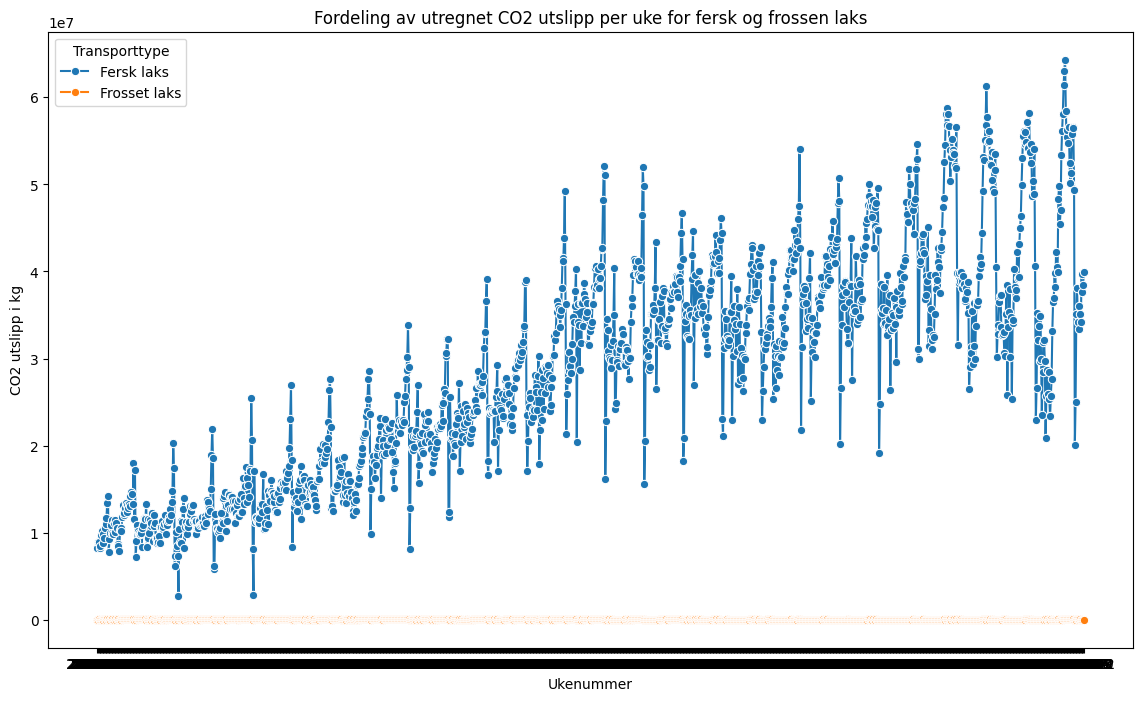

In [4]:

import seaborn as sns
import matplotlib.pyplot as plt

#Denne koden bruker df_summary for å vise co2 utslipp

plt.figure(figsize=(14, 8))
sns.lineplot(data = df_summary , x="År og ukenr.", y="Total CO2-utslipp (kg)", hue="Transporttype", marker="o")

df_summary["År og ukenr."] = range(1, len(df_summary) + 1)
plt.legend(title="Transporttype", loc="upper left", fontsize=10)
plt.title("Fordeling av utregnet CO2 utslipp per uke for fersk og frossen laks")
plt.xlabel("Ukenummer")
plt.ylabel("CO2 utslipp i kg") #det er ikke co2 utslipp for frossen laks fordi vi antar de er konstant og blir fraktet med skip



plt.show()

In [8]:
import requests
import pandas as pd
from itertools import product
from pandasql import sqldf
import plotly.graph_objects as go

# ------------------------------------------
# 1. Hent data fra SSB
# ------------------------------------------
API_URL = "https://data.ssb.no/api/v0/no/table/03024/"

def fetch_data(api_url=API_URL):
    query = {"query": [], "response": {"format": "json-stat2"}}
    response = requests.post(api_url, json=query)
    response.raise_for_status()
    return response.json()

# ------------------------------------------
# 2. Prosesser og pivotér data
# ------------------------------------------
def process_data(data):
    dimension_names = list(data["dimension"].keys())
    values = data["value"]
    dimensions = [list(data["dimension"][dim]["category"]["label"].values()) for dim in dimension_names]
    all_combinations = list(product(*dimensions))
    
    df = pd.DataFrame(all_combinations, columns=dimension_names)
    df["Value"] = values
    
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"],
                              values="Value", aggfunc="sum").reset_index()
    
    df_pivot.columns = ["År og ukenr.", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)",
                        "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]
    
    return df_pivot

# ------------------------------------------
# 3. Beregn CO₂-utslipp
# ------------------------------------------
CO2_FACTORS = {
    "Fersk laks": 1.1,     # kg CO₂ per tonn-km
    "Frosset laks": 0.01   # kg CO₂ per tonn-km
}
DISTANCES = {
    "Fersk laks": 2000,    # km
    "Frosset laks": 5000
}

def beregn_co2(df):
    df_melted = pd.melt(df,
        id_vars=["År og ukenr."],
        value_vars=["Fersk laks - Vekt (tonn)", "Frosset laks - Vekt (tonn)"],
        var_name="Type", value_name="Vekt (tonn)"
    )
    df_melted.dropna(subset=["Vekt (tonn)"], inplace=True)
    df_melted["Transporttype"] = df_melted["Type"].apply(lambda x: "Fersk laks" if "Fersk" in x else "Frosset laks")
    
    df_melted["CO2-utslipp (kg)"] = [
        vekt * CO2_FACTORS[typ] * DISTANCES[typ]
        for vekt, typ in zip(df_melted["Vekt (tonn)"], df_melted["Transporttype"])
    ]
    return df_melted

# ------------------------------------------
# 4. Oppsummer CO₂ per uke
# ------------------------------------------
def total_utslipp_per_uke(df):
    query = """
    SELECT `År og ukenr.`, Transporttype,
           SUM(`CO2-utslipp (kg)`) AS `Total CO2-utslipp (kg)`
    FROM df
    GROUP BY `År og ukenr.`, Transporttype
    ORDER BY `År og ukenr.`
    """
    return sqldf(query)

# ------------------------------------------
# 5. Kjør alt
# ------------------------------------------
def main():
    data = fetch_data()
    df_pivot = process_data(data)
    df_clean = df_pivot.dropna(subset=["Fersk laks - Vekt (tonn)", "Frosset laks - Vekt (tonn)"], how="all")
    
    df_with_co2 = beregn_co2(df_clean)
    df_summary = total_utslipp_per_uke(df_with_co2)
    
    # Filtrer for fersk laks
    fersk = df_summary[df_summary["Transporttype"] == "Fersk laks"].copy()
    fersk["Uke"] = fersk["År og ukenr."].str.replace("U", "-")
    
    # Hent vekt for fersk laks
    fersk_vekter = df_pivot[["År og ukenr.", "Fersk laks - Vekt (tonn)"]]
    fersk = pd.merge(fersk, fersk_vekter, on="År og ukenr.", how="left")
    
    return fersk

# ------------------------------------------
# 6. Visualisering
# ------------------------------------------
df_fersk = main()

# Visualiser CO₂ og vekt tydelig

import plotly.graph_objects as go

fig = go.Figure()

# CO₂-utslipp (venstre y-akse)
fig.add_trace(go.Scatter(
    x=df_fersk["Uke"],
    y=df_fersk["Total CO2-utslipp (kg)"],
    name="CO₂-utslipp (kg)",
    mode="lines+markers",
    line=dict(color="blue", width=2),
    yaxis="y1"
))

# Fersk laks – vekt (høyre y-akse)
fig.add_trace(go.Scatter(
    x=df_fersk["Uke"],
    y=df_fersk["Fersk laks - Vekt (tonn)"],
    name="Fersk laks – Vekt (tonn)",
    mode="lines+markers",
    line=dict(color="red", width=2, dash="solid"),
    yaxis="y2"
))


fig.update_layout(
    title="CO₂-utslipp og vekt av fersk laks per uke",
    xaxis=dict(title="Uke"),
    yaxis=dict(
        title=dict(text="CO₂-utslipp (kg)", font=dict(color="blue")),
        tickfont=dict(color="blue"),
        side="left"
    ),
    yaxis2=dict(
        title=dict(text="Vekt (tonn)", font=dict(color="red")),
        tickfont=dict(color="red"),
        overlaying="y",
        side="right"
    ),
    legend=dict(x=0.01, y=0.99),
    template="plotly_white",
    height=650
)


fig.show()

